In [ ]:
import numpy as np
from collections import Counter
import nltk
from functools import reduce

# Experiment 1: Using different embedding technique (word2vec/TF-IDF) with Vanilla RNN and LSTM

## Word2Vec

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

base_dir = '/content/drive/MyDrive/'
data_dir = base_dir+'CS505_final_shared_folder/df_final.csv'
data_dir_oversample = base_dir+'CS505_final_shared_folder/df_final_oversample.csv'
df = pd.read_csv(data_dir)
df_oversample = pd.read_csv(data_dir_oversample)

### Step 1: preprocess the data

In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing to each text entry
df['Processed_Text'] = df['Merged_Text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


KeyboardInterrupt: ignored

### Step 2: Creating Vocabulary and Preparing Data

In [ ]:
from collections import Counter
from torch.utils.data import Dataset, DataLoader

# Create vocabulary
all_words = [word for tokens in data['Processed_Text'] for word in tokens]
vocab = set(all_words)
word_to_ix = {word: i for i, word in enumerate(vocab)}

# Skip-Gram dataset
class SkipGramDataset(Dataset):
    def __init__(self, text_data, window_size=2):
        self.data = []
        for tokens in text_data:
            for i, word in enumerate(tokens):
                for j in range(max(i - window_size, 0), min(i + window_size + 1, len(tokens))):
                    if i != j:
                        self.data.append((word_to_ix[tokens[i]], word_to_ix[tokens[j]]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = SkipGramDataset(data['Processed_Text'])
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Word2Vec model
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Word2Vec, self).__init__()
        self.in_embed = nn.Embedding(vocab_size, embed_dim)
        self.out_embed = nn.Linear(embed_dim, vocab_size)  # Output layer

    def forward(self, input_words):
        input_vectors = self.in_embed(input_words)
        out_logits = self.out_embed(input_vectors)  # Logits for each word in vocab
        return out_logits

# Model, loss, and optimizer
embed_dim = 100
model = Word2Vec(len(vocab), embed_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in tqdm(range(5)):
    total_loss = 0
    for context, target in dataloader:
        context_var = context.unsqueeze(1).to(device)  # Ensure correct shape
        target = target.to(device)

        optimizer.zero_grad()
        log_probs = model(context_var)
        loss = criterion(log_probs.squeeze(), target)  # Context is the input, target is the prediction
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss}")

  0%|          | 0/5 [39:00<?, ?it/s]


KeyboardInterrupt: ignored

## TF-IDF

In [4]:
import torch
import torch.nn as nn
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizer = TfidfVectorizer()

# Fitting the model and transforming the 'Merged_Text' column
tfidf_matrix = vectorizer.fit_transform(df['Merged_Text'])

# Viewing the shape of the TF-IDF matrix
tfidf_matrix.shape

(44669, 168355)

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import math


tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Merged_Text'])

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['Score'], test_size=0.2, random_state=42)

def batch_generator(X, y, batch_size=16):
    num_samples = X.shape[0]
    num_batches = math.ceil(num_samples / batch_size)

    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, num_samples)

        # Process the batch
        X_batch = X[start_index:end_index].toarray()
        y_batch = np.eye(5)[y[start_index:end_index]]  # 5 Classes

        # Find the max_length for this batch
        max_length = int(np.percentile([len(x) for x in X_batch], 90))

        # Padding/truncating the sequences
        X_batch_padded = np.array([np.pad(x, (0, max_length - len(x)), 'constant') for x in X_batch])

        # Convert to PyTorch tensors
        X_batch_tensor = torch.tensor(X_batch_padded, dtype=torch.float32)
        y_batch_tensor = torch.tensor(y_batch, dtype=torch.float32)

        yield X_batch_tensor, y_batch_tensor

In [6]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

model = VanillaRNN(input_size=1, hidden_size=50, output_size=5)  # Adjust these parameters as needed

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
from tqdm import tqdm

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2

for epoch in tqdm(range(num_epochs)):
    model.train()

    for X_batch, y_batch in batch_generator(X_train, y_train):
        # Move data to the same device as the model
        X_batch = X_batch.to(device).reshape(X_batch.shape[0], X_batch.shape[1], 1)  # Reshape for RNN
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, torch.max(y_batch, 1)[1])

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

 50%|█████     | 1/2 [14:14<14:14, 854.16s/it]

Epoch [1/2], Loss: 1.7613


100%|██████████| 2/2 [28:26<00:00, 853.12s/it]

Epoch [2/2], Loss: 1.7615


In [9]:
model.eval()  # Set the model to evaluation mode
total = 0
correct = 0

with torch.no_grad():
    for X_batch, y_batch in batch_generator(X_test, y_test):
        # Move data to the same device as the model
        X_batch = X_batch.to(device).reshape(X_batch.shape[0], X_batch.shape[1], 1)  # Reshape for RNN
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == torch.max(y_batch, 1)[1]).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total}%')

Accuracy of the model on the test set: 22.46474143720618%


### Now we use the oversampled data

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import math

vectorizer = TfidfVectorizer()

# Fitting the model and transforming the 'Merged_Text' column
tfidf_matrix = vectorizer.fit_transform(df_oversample['Merged_Text'])

# Viewing the shape of the TF-IDF matrix
tfidf_matrix.shape

(50000, 169332)

In [12]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_oversample['Merged_Text'])

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df_oversample['Score'], test_size=0.2, random_state=42)

def batch_generator(X, y, batch_size=16):
    num_samples = X.shape[0]
    num_batches = math.ceil(num_samples / batch_size)

    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, num_samples)

        # Process the batch
        X_batch = X[start_index:end_index].toarray()
        y_batch = np.eye(5)[y[start_index:end_index]]  # 5 Classes

        # Find the max_length for this batch
        max_length = int(np.percentile([len(x) for x in X_batch], 90))

        # Padding/truncating the sequences
        X_batch_padded = np.array([np.pad(x, (0, max_length - len(x)), 'constant') for x in X_batch])

        # Convert to PyTorch tensors
        X_batch_tensor = torch.tensor(X_batch_padded, dtype=torch.float32)
        y_batch_tensor = torch.tensor(y_batch, dtype=torch.float32)

        yield X_batch_tensor, y_batch_tensor

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
model = VanillaRNN(input_size=1, hidden_size=50, output_size=5)

In [15]:
from tqdm import tqdm

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2

for epoch in tqdm(range(num_epochs)):
    model.train()

    for X_batch, y_batch in batch_generator(X_train, y_train):
        # Move data to the same device as the model
        X_batch = X_batch.to(device).reshape(X_batch.shape[0], X_batch.shape[1], 1)  # Reshape for RNN
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, torch.max(y_batch, 1)[1])

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

 50%|█████     | 1/2 [16:02<16:02, 962.45s/it]

Epoch [1/2], Loss: 1.6132


100%|██████████| 2/2 [32:06<00:00, 963.18s/it]

Epoch [2/2], Loss: 1.6123


In [16]:
model.eval()  # Set the model to evaluation mode
total = 0
correct = 0

with torch.no_grad():
    for X_batch, y_batch in batch_generator(X_test, y_test):
        # Move data to the same device as the model
        X_batch = X_batch.to(device).reshape(X_batch.shape[0], X_batch.shape[1], 1)  # Reshape for RNN
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == torch.max(y_batch, 1)[1]).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total}%')

Accuracy of the model on the test set: 19.83%


# Experiment 2: Exploring the performance of different LLMs on our Multi-class classification task

## BERT model:

We will use pre-trained BERT model and fine-tune it with each classes text. So that I could generate realistic review texts.

We will create an another ipynb file for text generation. And then we are going to use pipeline to generate samples.

In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.7 MB/s eta 0:00:00


### In this part, we will use non-oversampled data

In [ ]:
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

data = pd.read_csv(data_dir)

train_texts, temp_texts, train_labels, temp_labels = train_test_split(data['Merged_Text'], data['Score'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

train_texts.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_texts.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)
test_texts.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128
batch_size = 16

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = TextDataset(val_texts, val_labels, tokenizer, max_len)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from transformers import BertForSequenceClassification, AdamW

# Set Up BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(data['Score'].unique()))
optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in tqdm(val_loader, desc="Validation"):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    avg_val_loss = total_eval_loss / len(val_loader)

    print(f'Epoch {epoch + 1}')
    print(f'Training Loss: {avg_train_loss}')
    print(f'Validation Loss: {avg_val_loss}')
    print(f'Validation Accuracy: {avg_val_accuracy}')

Validation: 100%|██████████| 469/469 [01:17<00:00,  6.04it/s]


Epoch 1
Training Loss: 0.8351744140142496
Validation Loss: 0.9576794267463278
Validation Accuracy: 0.6039001421464109


Validation: 100%|██████████| 469/469 [01:16<00:00,  6.13it/s]


Epoch 2
Training Loss: 0.6145278953383566
Validation Loss: 1.0749866741298357
Validation Accuracy: 0.6029673063255153


Validation: 100%|██████████| 469/469 [01:16<00:00,  6.11it/s]

Epoch 3
Training Loss: 0.42884340916693864
Validation Loss: 1.2588270586182568
Validation Accuracy: 0.6002576403695806


Evaluating: 100%|██████████| 469/469 [01:12<00:00,  6.50it/s]


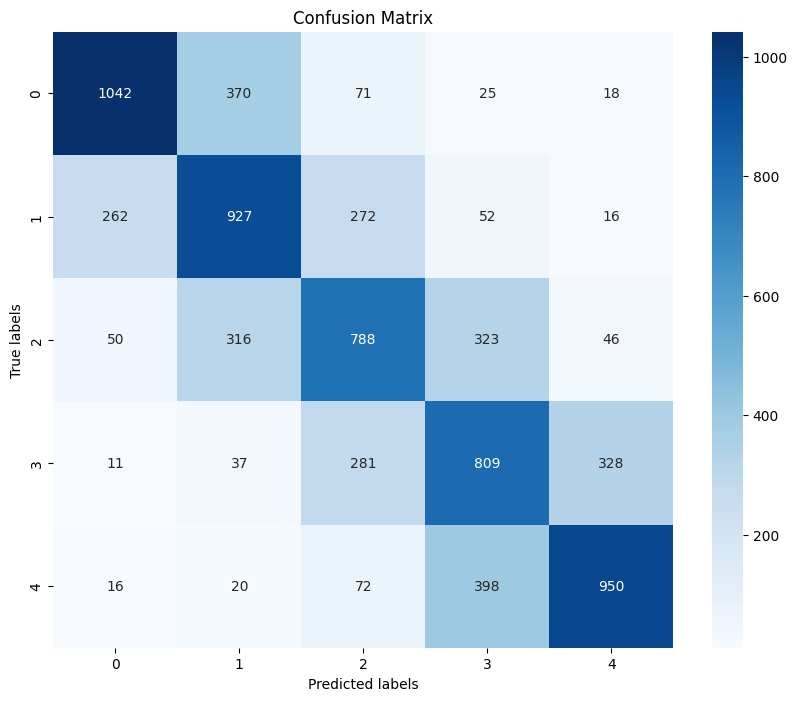

Accuracy: 0.6021
Precision: 0.6087
Recall: 0.6021
F1 Score: 0.6044


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_names = data['Score'].unique()
class_names.sort()  # Sort the class names if necessary
class_names = class_names.tolist()  # Convert to a list if it's not already

class_names = [str(name) for name in class_names]

def evaluate_model(model, test_loader, device, class_names):
    model.eval()

    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            predictions.append(logits)
            true_labels.append(label_ids)

    predictions = np.concatenate(predictions, axis=0)
    predictions = np.argmax(predictions, axis=1).flatten()
    true_labels = np.concatenate(true_labels, axis=0)

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

    return accuracy, precision, recall, f1, cm

accuracy, precision, recall, f1, cm = evaluate_model(model, test_loader, device, class_names)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

### Now, we'll see the effect of oversampling

In [ ]:
data = pd.read_csv(data_dir_oversample)

train_texts, temp_texts, train_labels, temp_labels = train_test_split(data['Merged_Text'], data['Score'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

train_texts.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_texts.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)
test_texts.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)

In [ ]:
train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = TextDataset(val_texts, val_labels, tokenizer, max_len)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(data['Score'].unique()))
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in tqdm(val_loader, desc="Validation"):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    avg_val_loss = total_eval_loss / len(val_loader)

    print(f'Epoch {epoch + 1}')
    print(f'Training Loss: {avg_train_loss}')
    print(f'Validation Loss: {avg_val_loss}')
    print(f'Validation Accuracy: {avg_val_accuracy}')

Validation: 100%|██████████| 469/469 [01:16<00:00,  6.10it/s]


Epoch 1
Training Loss: 1.0491968382837786
Validation Loss: 0.943722163563344
Validation Accuracy: 0.5920842217484008


Validation: 100%|██████████| 469/469 [01:16<00:00,  6.13it/s]


Epoch 2
Training Loss: 0.8143795377811522
Validation Loss: 0.9304884559691333
Validation Accuracy: 0.6079424307036247


Validation: 100%|██████████| 469/469 [01:16<00:00,  6.11it/s]

Epoch 3
Training Loss: 0.638572247375409
Validation Loss: 1.0351443504537348
Validation Accuracy: 0.6031005685856432


Evaluating: 100%|██████████| 469/469 [01:11<00:00,  6.56it/s]


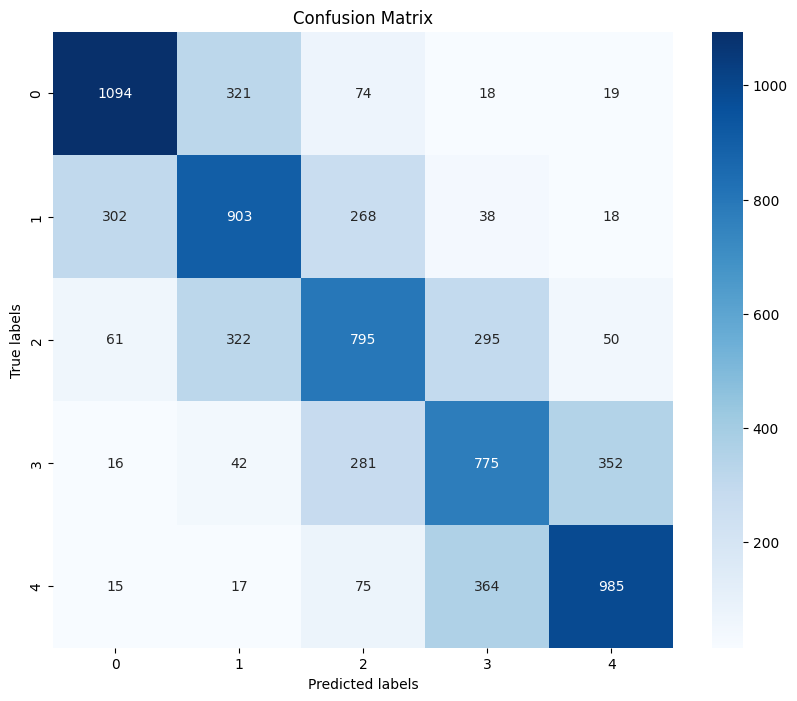

Accuracy: 0.6069
Precision: 0.6084
Recall: 0.6069
F1 Score: 0.6075


In [ ]:
accuracy, precision, recall, f1, cm = evaluate_model(model, test_loader, device, class_names)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")